### MLP


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split

In [2]:

class GA_MLP:

    def __init__(self, input_dim, hidden_dims, output_dim, population_size, X, y):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.structure = [self.input_dim] + self.hidden_dims + [self.output_dim]
        
        self.population_size = population_size
        self.X = X
        self.y = y
        
        self.generations_best_scores = []
        self.generation_mean = []
        self.best_mlp = None
        self.best_value = -1
        
        self.generation_weights = [
            [np.random.uniform(-1, 1, size=(prev_size, curr_size))for prev_size, curr_size in zip(self.structure[:-1], self.structure[1:])]
            for _ in range(self.population_size)
        ]
        
        self.generation_biases = [
            [np.random.uniform(-1, 1, size=(1, curr_size)) for curr_size in self.structure[1:]]
             for _ in range(self.population_size)
        ]
      
        
    def forward(self, inputs, weights, biases):
        activations = inputs
        for i in range(len(self.structure)-2):
            output = activations @ weights[i] + biases[i]
            activations = 1 / (1 + np.exp(-output))
        result = activations @ weights[-1] + biases[-1]
        return result
    
        
        

    def evolve(self, generations, mutation_coef, crossover_coef):
        
        for generation in range(1,generations+1):
            if generation != 1 and (generation) % 10 == 0:
                print(f"{generation}/{generations} | best = {1/self.best_value:.3f} | mean = {1/self.generation_mean[-1]}", end="\r")
                
            crossed_weights, crossed_biases = self.crossover(crossover_coef)
            mutated_w, mutated_b = self.mutate(mutation_coef)
            
            population_w = self.generation_weights + crossed_weights + mutated_w
            population_b = self.generation_biases + crossed_biases + mutated_b

            # evaluation
            scores = np.asarray([self.evaluate(population_w[i], population_b[i]) for i in range(len(population_w))])
            self.generation_mean.append(np.mean(scores))
            best_value_index = np.argmax(scores)
            self.generations_best_scores.append(scores[best_value_index])
            if scores[best_value_index] > self.best_value:
                self.best_mlp = [population_w[best_value_index], population_b[best_value_index]]
                self.best_value = scores[best_value_index]
            
            # elite
            prob = scores/scores.sum()
            population_fraction = int(np.floor(0.1*self.population_size))
            choices = np.random.choice([i for i in range(len(population_w))], size=self.population_size-population_fraction, p=prob)
            self.generation_weights = [self.best_mlp[0] for _ in range(population_fraction)]
            self.generation_biases = [self.best_mlp[1] for _ in range(population_fraction)]
            for choice in choices:
                self.generation_weights.append(population_w[choice])
                self.generation_biases.append(population_b[choice])
            
    
    def evaluate(self, weights, biases):
        pred = self.forward(self.X, weights, biases)
        return 1/mean_squared_error(self.y, pred)



    
    def crossover(self, crossover_coef):
        choices = np.random.choice(self.population_size, int(np.floor(crossover_coef*self.population_size)), replace=False)
        parents_weights = []
        parents_biases = []
        for choice in choices:
            parents_weights.append(self.generation_weights[choice])
            parents_biases.append(self.generation_biases[choice])

            
        children_w = []
        children_b = []
        for i in range(0, len(parents_weights)-1, 2):
            
            split = np.random.randint(len(parents_weights[i])-1)
            [child_1_w, child_2_w, child_1_b, child_2_b] = [[],[],[],[]]
            
            for j in range(len(parents_biases[i])):
                if j <= split:
                    child_1_w.append(parents_weights[i][j])
                    child_2_w.append(parents_weights[i+1][j])
                    
                    child_1_b.append(parents_biases[i][j])
                    child_2_b.append(parents_biases[i+1][j])
                else:
                    child_1_w.append(parents_weights[i+1][j])
                    child_2_w.append(parents_weights[i][j])
                    
                    child_1_b.append(parents_biases[i+1][j])
                    child_2_b.append(parents_biases[i][j])
                    
            children_w.append(child_1_w)
            children_w.append(child_2_w)
            
            children_b.append(child_1_b)
            children_b.append(child_2_b)
        return children_w, children_b

    
    def mutate(self, mutation_coef):
        choices = np.random.choice(self.population_size, int(np.floor(mutation_coef*self.population_size)), replace=False)
        weights_for_mutation = []
        biases_for_mutation = []
        for choice in choices:
            weights_for_mutation.append(self.generation_weights[choice])
            biases_for_mutation.append(self.generation_biases[choice])
        mutated_w = []
        mutated_b = []
        for i in range(len(weights_for_mutation)):
            w = weights_for_mutation[i]
            b = biases_for_mutation[i]
            mutated_w.append([elem + np.random.normal(0,1,size=(elem.shape[0],elem.shape[1])) for elem in w])
            mutated_b.append([elem + np.random.normal(0,1,size=(elem.shape[0],elem.shape[1])) for elem in b])
        return mutated_w, mutated_b
        
    
    

In [5]:
df = pd.read_table("data/iris.data", sep=",", header=None)
X = df.iloc[:,:4]
iris_dict = {
    "Iris-setosa" : 0,
    "Iris-versicolor" : 1,
    "Iris-virginica" :2
}
y = df.iloc[:,4]
y = y.map(iris_dict)

In [5]:
ga_mlp = GA_MLP(4, [10,10], 1, 100, X.values, y.values)
ga_mlp.evolve(300, 0.5, 0.2)


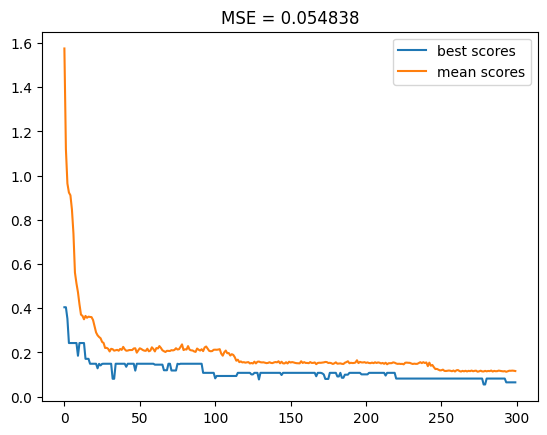

In [6]:
plt.plot(1/np.array(ga_mlp.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp.generation_mean), label="mean scores")
plt.title(f"MSE = {1/ga_mlp.best_value:.6f}")
plt.legend()
plt.show()

### multimodal

In [3]:
df = pd.read_csv("data/multimodal-large-training.csv")
X = df["x"].values.reshape(-1,1)
y = df["y"]

In [4]:
ga_mlp = GA_MLP(1, [30,30], 1, 40, X, y.values)
ga_mlp.evolve(500, 0.3, 0.3)

KeyboardInterrupt: 

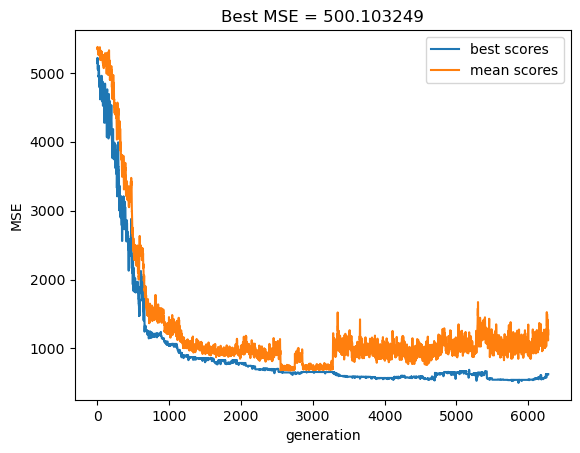

In [118]:
plt.plot(1/np.array(ga_mlp.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp.generation_mean), label="mean scores")
plt.title(f"Best MSE = {1/ga_mlp.best_value:.6f}")
plt.xlabel("generation")
plt.ylabel("MSE")
plt.legend()
plt.show()

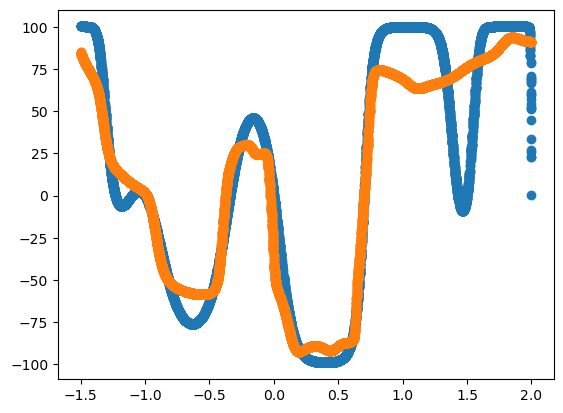

In [119]:
plt.scatter(X, y, label="data")
plt.scatter(X, ga_mlp.forward(X, ga_mlp.best_mlp[0], ga_mlp.best_mlp[1]))
plt.show()

In [5]:
ga_mlp1 = GA_MLP(1, [100], 1, 50, X, y.values)
ga_mlp1.evolve(2000, 0.7, 0.2)

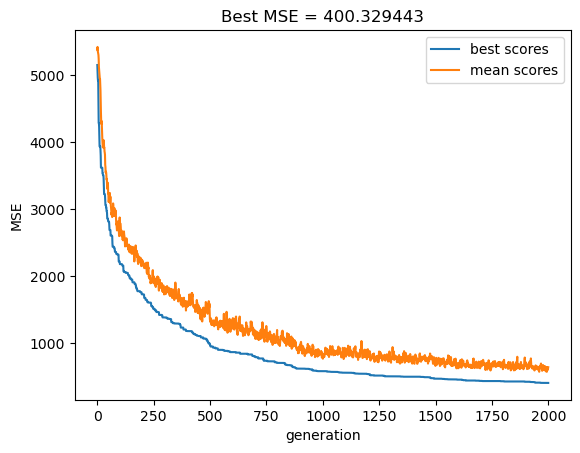

In [6]:
plt.plot(1/np.array(ga_mlp1.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp1.generation_mean), label="mean scores")
plt.title(f"Best MSE = {1/ga_mlp1.best_value:.6f}")
plt.xlabel("generation")
plt.ylabel("MSE")
plt.legend()
plt.show()

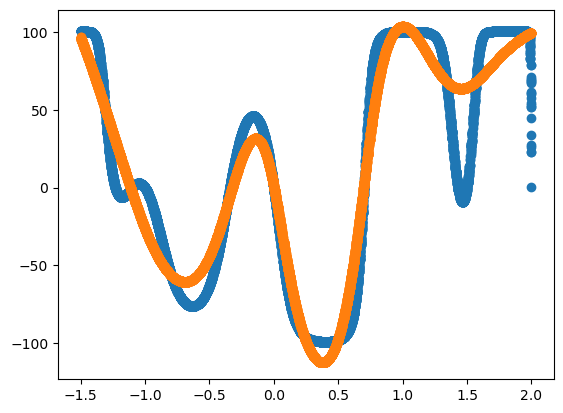

In [7]:
plt.scatter(X, y, label="data")
plt.scatter(X, ga_mlp1.forward(X, ga_mlp1.best_mlp[0], ga_mlp1.best_mlp[1]))
plt.show()

In [13]:
ga_mlp2 = GA_MLP(1, [100], 1, 100, X, y.values)
ga_mlp2.evolve(2000, 0.3, 0.1)

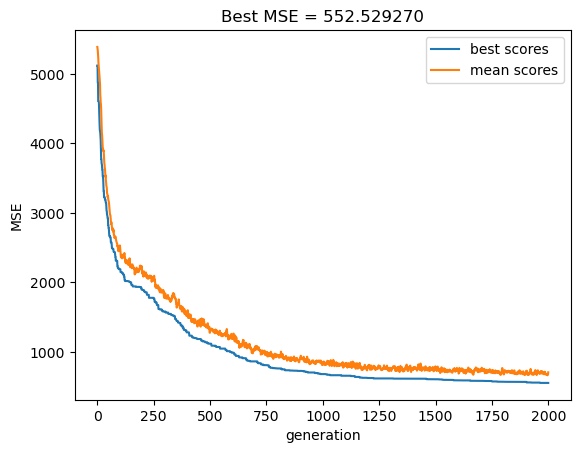

In [14]:
plt.plot(1/np.array(ga_mlp2.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp2.generation_mean), label="mean scores")
plt.title(f"Best MSE = {1/ga_mlp2.best_value:.6f}")
plt.xlabel("generation")
plt.ylabel("MSE")
plt.legend()
plt.show()

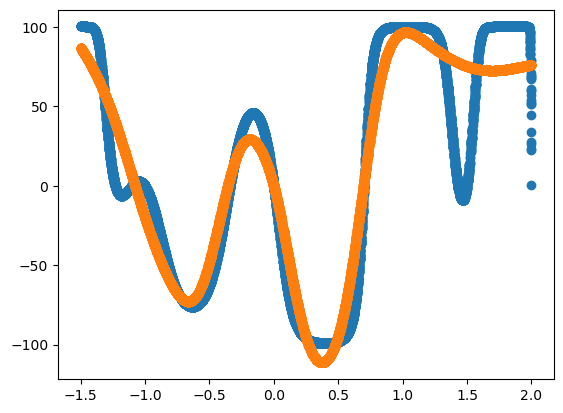

In [15]:
plt.scatter(X, y, label="data")
plt.scatter(X, ga_mlp2.forward(X, ga_mlp2.best_mlp[0], ga_mlp2.best_mlp[1]))
plt.show()

In [8]:
ga_mlp3 = GA_MLP(1, [20,20,20], 1, 100, X, y.values)
ga_mlp3.evolve(2000, 0.7, 0.2)

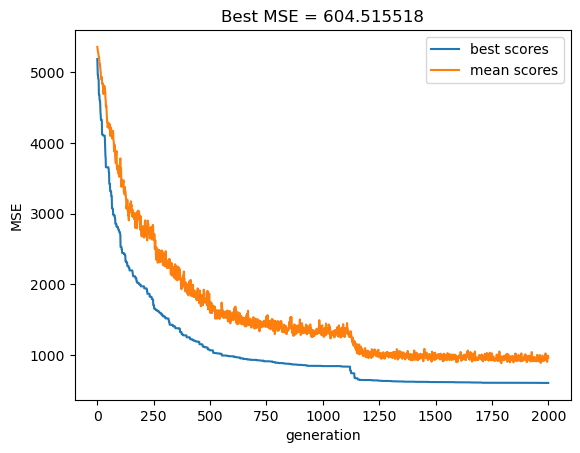

In [9]:
plt.plot(1/np.array(ga_mlp3.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp3.generation_mean), label="mean scores")
plt.title(f"Best MSE = {1/ga_mlp3.best_value:.6f}")
plt.xlabel("generation")
plt.ylabel("MSE")
plt.legend()
plt.show()

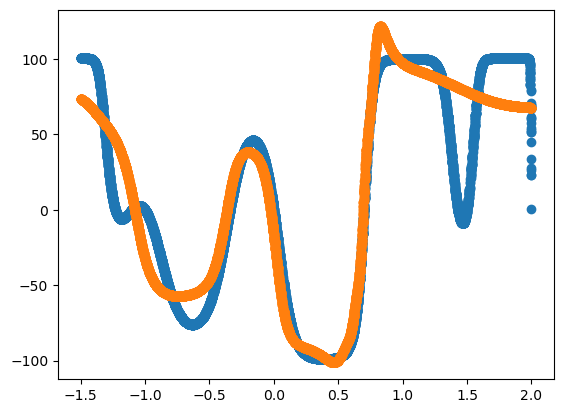

In [10]:
plt.scatter(X, y, label="data")
plt.scatter(X, ga_mlp3.forward(X, ga_mlp3.best_mlp[0], ga_mlp3.best_mlp[1]))
plt.show()

In [17]:
ga_mlp4 = GA_MLP(1, [20,20,20], 1, 100, X, y.values)
ga_mlp4.evolve(2000, 0.3, 0.1)

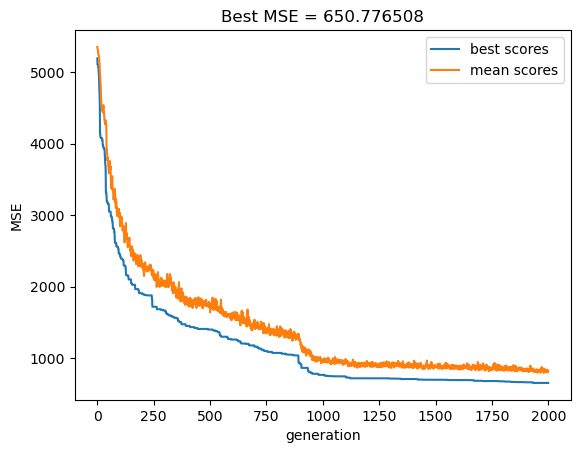

In [18]:
plt.plot(1/np.array(ga_mlp4.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp4.generation_mean), label="mean scores")
plt.title(f"Best MSE = {1/ga_mlp4.best_value:.6f}")
plt.xlabel("generation")
plt.ylabel("MSE")
plt.legend()
plt.show()

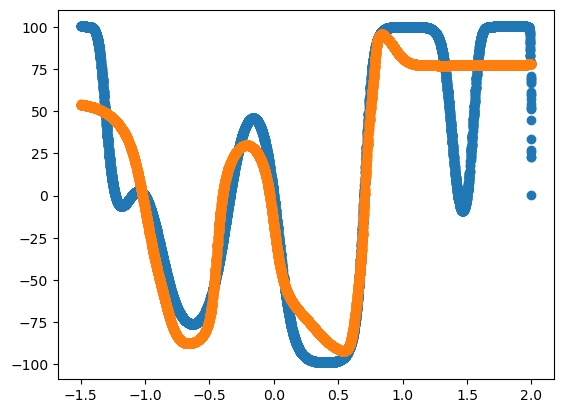

In [19]:
plt.scatter(X, y, label="data")
plt.scatter(X, ga_mlp4.forward(X, ga_mlp4.best_mlp[0], ga_mlp4.best_mlp[1]))
plt.show()

### auto-mpg

In [50]:
df = pd.read_fwf("data/auto-mpg.data",sep=" ",header=None)
df.columns = ["mpg", "cylinders", "displacement","horsepower", "weight", "acceleration","model_year","origin", "car_name"]
y = df.iloc[:,0] #mpg
X = df.iloc[:,1:8]
indices = ~(X.iloc[:,2] == "?")
X = X.loc[indices,:]
y = y.loc[indices]
X["horsepower"] = pd.to_numeric(X["horsepower"])

In [60]:
warnings.filterwarnings("ignore")
ga_mlp = GA_MLP(7, [30,30,30], 1, 100, X.values, y.values)
ga_mlp.evolve(200, 0.5, 0.2)
warnings.filterwarnings("default")


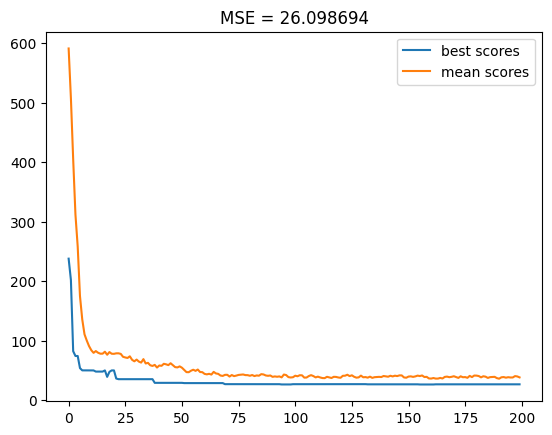

In [61]:
plt.plot(1/np.array(ga_mlp.generations_best_scores), label="best scores")
plt.plot(1/np.array(ga_mlp.generation_mean), label="mean scores")
plt.title(f"MSE = {1/ga_mlp.best_value:.6f}")
plt.legend()
plt.show()